# LSTM EN-DE 32 Classes

The bidirectional LSTM is trained on sentence level on English and German data. There are two evaluations, one on sentence level and one on document level

In [0]:
# Imports
import os
import keras
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding as emb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn
from keras.utils import generic_utils 
from sklearn.preprocessing import LabelEncoder


# Setting seed to get reproducable results
from numpy.random import seed
from tensorflow import set_random_seed
SEED = 13
seed(SEED)
set_random_seed(SEED)

Using TensorFlow backend.


## Setting Up Google Drive
The data used in this notebook is available in my drive.

The  bilingual word embedding created from the large legal corpus is also in the drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
embding_path = '/content/gdrive/My Drive/en.de.context.emb'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Getting the data

The data is pickled and hence unpickling it here.


In [0]:
# unpickle data
import pickle
def unpickle(obj):
    with open(obj, 'rb') as picklehandle:
        toReturn = pickle.load(picklehandle)
    return toReturn

en_de_combined = unpickle('/content/combined_data.pkl')
label = unpickle('/content/en-de-label.pkl')

## Test Train Split

Before doing anything, Split the data into test and train sets, so there is no information leak from train data to test data.
This is not a problem in case of one language as every instance is either in train or test set, but in case of multilingual data it might so happen that a document from one language is in  train set and the same document from another language might end up in test set, this might be a problem, and to avoid it we split the data as soon as we have it.

In [0]:
# Initial Test Train Split
train_data, test_data, train_la, test_la = train_test_split(en_de_combined, label,test_size=0.3, random_state=SEED)

## EN-DE data combination

Instead of seperating the data for english and german I will combine both.

In [0]:
def prepare_data(data, label):
    """prepare data from combined data, it is seperated by '\n\n\n', three new line charaters
    Returns: english data, german data, file name, doc_id, multiple labels
    """
    en_de_data = [] 
    file_name = []
    doc_id = []
    multilabel = []
    labels = []
    
    """NOTE:
        As I am adding the english and german data after one another, I have to do the same for all other data that are coming from that combined list
    """
    
    if isinstance(data, list):
        for doc, l in zip(data,label):
            en_de_data.append(doc.split('\n\n\n')[0])
            en_de_data.append(doc.split('\n\n\n')[1])
            file_name.append(doc.split('\n\n\n')[2])
            doc_id.append(doc.split('\n\n\n')[3])
            multilabel.append(doc.split('\n\n\n')[4])
            labels.append(l)
            file_name.append(doc.split('\n\n\n')[2])
            doc_id.append(doc.split('\n\n\n')[3])
            multilabel.append(doc.split('\n\n\n')[4])
            labels.append(l)
    return en_de_data, file_name, doc_id, multilabel, labels

In [0]:
# Preparing train and test data
train_data, train_file_name, train_doc_id, train_multilabel, train_label = prepare_data(train_data, train_la)
test_data, test_file_name, test_doc_id, test_multilabel, test_label = prepare_data(test_data, test_la)

In [0]:
len(train_data), len(train_label), len(test_data), len(test_label)

(3802, 3802, 1630, 1630)

## Sliding Window

Sliding window, helper function to chunk the incoming document into predefined chuck length and step size

In [0]:
def slidingWindow(sequence,winSize,step):
    """Returns a generator that will iterate through
    the defined chunks of input sequence. Input sequence
    must be sliceable."""

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,round(numOfChunks)*step,step):
        yield sequence[i:i+winSize]

## Numbering Labels

Manually labeling the alpha labels as the evaluation based on documents will require more control over the label  

In [0]:
# Numbering the labels
label_num = dict(enumerate(sorted(set(label))))
label_num

{0: 'agriculture',
 1: 'audiovisual_and_media',
 2: 'budget',
 3: 'competition',
 4: 'consumers',
 5: 'culture',
 6: 'customs',
 7: 'development',
 8: 'economic_and_monetary_affairs',
 9: 'education_training_youth',
 10: 'employment_and_social_policy',
 11: 'energy',
 12: 'enlargement',
 13: 'enterprise',
 14: 'environment',
 15: 'external_relations',
 16: 'external_trade',
 17: 'fight_against_fraud',
 18: 'food_safety',
 19: 'foreign_and_security_policy',
 20: 'human_rights',
 21: 'humanitarian_aid',
 22: 'information_society',
 23: 'institutional_affairs',
 24: 'internal_market',
 25: 'justice_freedom_security',
 26: 'maritime_affairs_and_fisheries',
 27: 'public_health',
 28: 'regional_policy',
 29: 'research_innovation',
 30: 'taxation',
 31: 'transport'}

## Train Sentence preparation German

From the training documents we are creating sentences and the giving them corresponding numeric labels to each sentence

In [0]:
# Train data preparation
_train_sentence = []
_train_label = []

for doc, labe in zip(train_data, train_label):
    # call the sliding window on doc
    
    slides = slidingWindow(doc.split(' '), 30, 10)
    
    # get the num label 
    for key, value in label_num.items():
        if value == labe:
            num = key
            
      
    for slide in slides:
        _train_sentence.append(slide)
        _train_label.append(num)


# ensuring the number of samples in train set and labels
print(len(_train_sentence), len(_train_label))

221544 221544


## Tokenizing training sentence

Toknizing the training sentences and then fitting it on train sentence and then use the same tokenizer object on test data
Also calculate the vocabulary size which we will need in the embedding layer. 

In [0]:
# tokenizing Sentences Using Keras tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()

# Tokenizing the sentences (This process may take some time depending on your corpus size)
tokenizer.fit_on_texts(_train_sentence)

# Lets see what our vocabulary size is
vocab_size = len(tokenizer.word_index) + 1   # We are adding 1 here because it takes indexing from zero
print("Vocabulary size is: {}".format(vocab_size))

# Sentence encoding (it means we are now converting words into numbers)
sent_encoded = tokenizer.texts_to_sequences(_train_sentence)
print("The number of sentence in train set after encoding: {}".format(len(sent_encoded)))


# Start padding with the 30, although we wont need it, but still as precautionary measure
max_len = len(_train_sentence[1])
print('Maximum length of sentences in training set is', max_len)
padded_sents = keras.preprocessing.sequence.pad_sequences(sent_encoded, maxlen=max_len, padding='post')

Vocabulary size is: 67730
The number of sentence in train set after encoding: 221544
Maximum length of sentences in training set is 30


In [0]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

# Embedding Matrix Creation

The bilingual embeddings that has been created on large law data will be used here 

In [0]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index = {}
with open(embding_path, 'r') as embpath:
    pretrained_embeding = embpath.readlines()
    
    for i, line in enumerate(pretrained_embeding):
        if i == 0:
            pass
        else:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
print('shape embedding matrix: {}'.format(embedding_matrix.shape))

shape embedding matrix: (67730, 200)


## One Hot Encoding Labels

The numerical labels needs to be converted into its one hot encoded form.

In [0]:
# Converting train labels into one hot encoded form
oht_obj = OneHotEncoder(sparse=False, categories='auto')
oht_obj.fit((np.reshape(_train_label, (-1,1))))

train_labels = oht_obj.transform((np.reshape(_train_label, (-1,1))))


## Callback

Two call backs are used here,

* *reduce_rate*:  Which helps in situation where we are stuck on a Plateau.
* *early_stopping*: It monitors the validation loss and in case of overfitting it will wait for the number of epochs given by user before stopping the leanring process.


In [0]:
# Other callbacks 
reduce_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0, verbose=1, 
                                                mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=2, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.




## Model Architecture

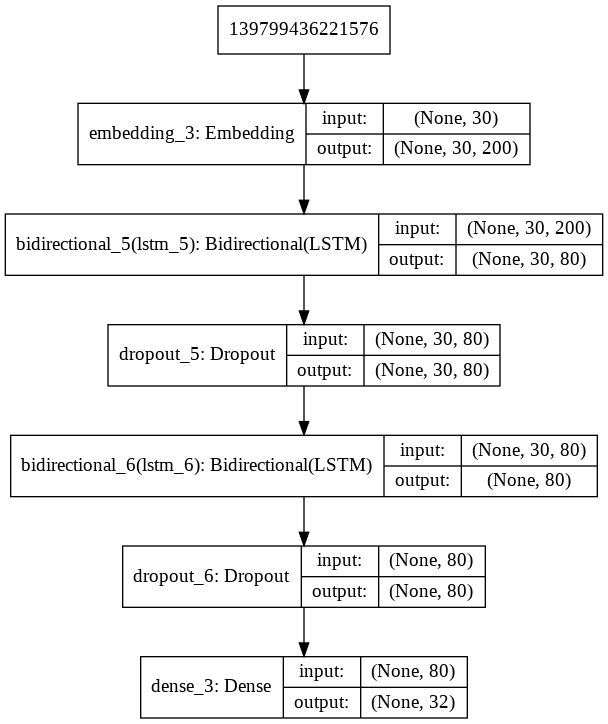

In [0]:
from IPython.display import Image
Image('/content/model.png')

In [0]:
# Create sequential model
model = Sequential()
model.add(emb(vocab_size, 200, weights=[embedding_matrix], input_length=30, trainable=False))   
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.04))))# LSTM layer 
model.add(keras.layers.Dropout(0.5))
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03))))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(32, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 200)           13546000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 80)            77120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2592      
Total params: 13,664,432
Trainable params: 118,432
Non-trainable params: 13,546,000
__________________________________________________________

In [0]:
# Model visualization
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
# Training the mdoel
history = model.fit(padded_sents, train_labels, validation_split=0.3, epochs=20, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 155080 samples, validate on 66464 samples
Epoch 1/20
155080/155080 [==============================] - 452s 3ms/step - loss: 2.8035 - acc: 0.3112 - val_loss: 2.6172 - val_acc: 0.3242
Epoch 2/20
155080/155080 [==============================] - 445s 3ms/step - loss: 2.4365 - acc: 0.3904 - val_loss: 2.5034 - val_acc: 0.3681
Epoch 3/20
155080/155080 [==============================] - 446s 3ms/step - loss: 2.3707 - acc: 0.4135 - val_loss: 2.4489 - val_acc: 0.3851
Epoch 4/20
155080/155080 [==============================] - 444s 3ms/step - loss: 2.3338 - acc: 0.4274 - val_loss: 2.4492 - val_acc: 0.3930

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
155080/155080 [==============================] - 444s 3ms/step - loss: 2.0714 - acc: 0.4766 - val_loss: 2.1635 - val_acc: 0.4403
Epoch 6/20
155080/155080 [==============================] - 450s 3ms/step - loss: 1.9986 - acc: 0.4858 - val_loss: 2.13

## Evaluation on Document Level

In [0]:
#Evaluation on Document Level
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

original_label = []   # list to store the original label 
predicted_label = []   # list to store the predicted label

for first_data, first_label in zip(test_data,test_label):
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in label_num.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide)
        
        doc_sent.append(a)
    
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer.texts_to_sequences(doc_sent)

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')


    # predict the label
    sent_pred.append(model.predict(text_padded))        
    
    # normailizing the predictions before combining them.
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    # adding all the predictions of sentences of a single document into one.
    sent = np.zeros(train_labels.shape[1])
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    # populating lists of the predicted labels and original labels for further evaluation
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)

In [0]:
# Accuracy on document level
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy of the model on document level is: {:.2f} %".format(accuracy_score(original_label, predicted_label)*100))

Accuracy of the model on document level is: 66.93 %


In [0]:
# Classification report and confusion Matrix
np.set_printoptions(threshold=np.nan)
print(confusion_matrix(original_label, predicted_label))

[[ 39   0   0   0   2   0   0   0   0   0   1   0   0   0   4   0   0   0
    3   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  10   0   0   0   0   0   0   0   0   0]
 [  1   0   9   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   5   0   1   0   0   2   0   0   0]
 [  0   0   0  19   0   0   0   0   0   0   0   0   2   0   0   0   1   0
    0   0   0   0   0   0   2   0   0   0   0   0   0   6]
 [  2   0   0   0  40   0   0   0   0   0   0   0   0   0   2   0   0   0
    2   0   0   0   0   1  15   5   0   0   0   0   0   7]
 [  0   2   0   0   0   0   0   0   0   7   0   0   0   0   0   0   0   0
    0   0   0   0   5   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  14   0   0   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   5   5   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0  29   0   0   1   0   0   0   1   0   3

In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        50
           1       0.00      0.00      0.00        10
           2       0.90      0.45      0.60        20
           3       0.90      0.63      0.75        30
           4       0.54      0.54      0.54        74
           5       0.00      0.00      0.00        14
           6       0.78      0.47      0.58        30
           7       0.45      0.81      0.57        36
           8       0.85      0.93      0.89        86
           9       0.64      0.94      0.77        52
          10       0.68      0.83      0.75        94
          11       0.71      0.71      0.71        56
          12       0.70      0.44      0.54        32
          13       0.44      0.15      0.23        26
          14       0.69      0.82      0.75        88
          15       1.00      0.23      0.37        44
          16       0.53      0.61      0.57        28
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Evaluation on Sentence level

In [0]:
# Train data preparation
_test_sentence = []
_test_label = []

for doc, labe in zip(test_data, test_label):
    # call the sliding window on doc
    
    slides = slidingWindow(doc.split(' '), 30, 10)
    
    # get the num label 
    for key, value in label_num.items():
        if value == labe:
            num = key
            
      
    for slide in slides:
        _test_sentence.append(slide)
        _test_label.append(num)


# ensuring the number of samples in train set and labels
print(len(_test_sentence), len(_test_label))


test_labels = oht_obj.fit_transform(np.reshape(_test_label,(-1,1)))
test_setences = tokenizer.texts_to_sequences(_test_sentence)


# Testing the data
paddedTestSents = keras.preprocessing.sequence.pad_sequences(test_setences, maxlen=max_len, padding='post')

95938 95938


In [0]:
scores = model.evaluate(paddedTestSents, test_labels, verbose=1)
print("Accuracy on sentence level: %.2f%%" % (scores[1]*100))

95938/95938 [==============================] - 70s 731us/step
Accuracy on sentence level: 44.10%


In [0]:
pred = model.predict(paddedTestSents)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

In [0]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.55      0.55      4421
           1       0.47      0.22      0.30       719
           2       0.42      0.21      0.28      1139
           3       0.54      0.34      0.42      1651
           4       0.33      0.34      0.33      3339
           5       0.50      0.00      0.01       652
           6       0.46      0.23      0.31      1964
           7       0.26      0.40      0.32      1986
           8       0.68      0.77      0.72      6914
           9       0.46      0.67      0.55      3027
          10       0.39      0.52      0.45      5064
          11       0.42      0.38      0.39      2702
          12       0.28      0.23      0.25      2462
          13       0.17      0.12      0.14      1330
          14       0.43      0.52      0.47      4149
          15       0.44      0.13      0.21      2793
          16       0.26      0.33      0.29      1451
          17       0.36    